Independent component analysis (ICA) is used to estimate sources given noisy measurements. Imagine 3 instruments playing simultaneously and 3 microphones recording the mixed signals. ICA is used to recover the sources ie. what is played by each instrument. Importantly, PCA fails at recovering our instruments since the related signals reflect non-Gaussian processes.

Generate sample data

In [1]:
import numpy as np
from scipy import signal

np.random.seed(0)
n_samples = 2000 # for x axis
time = np.linspace(0, 8, n_samples) # for y axis 

s1 = np.sin(2 * time)  # Signal 1 : sinusoidal signal
s2 = np.sign(np.sin(3 * time))  # Signal 2 : square signal
s3 = signal.sawtooth(2 * np.pi * time)  # Signal 3: saw tooth signal

S = np.c_[s1, s2, s3]## Mixing of Signals ( Ground Truth )
S += 0.2 * np.random.normal(size=S.shape)  # Add noise
#Now will standardize the data and take a basis vector which will decide the 
#proportion of mixing of signals with each other. 
#The observation mixture will be produced using dot product of basis vector A and signal mixture S

S /= S.std(axis=0)  # Standardize data
# Mix data
A = np.array([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]])  # Mixing matrix
# Create the Observation Data for ICA 
X = np.dot(S, A.T)  # Generate observations

Fit ICA and PCA models

In [2]:
from sklearn.decomposition import PCA, FastICA

# Compute ICA
ica = FastICA(n_components=3, whiten="arbitrary-variance")
S_ = ica.fit_transform(X)  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix

# We can `prove` that the ICA model applies by reverting the unmixing.
assert np.allclose(X, np.dot(S_, A_.T) + ica.mean_)

# For comparison, compute PCA
pca = PCA(n_components=3)
H = pca.fit_transform(X)  # Reconstruct signals based on orthogonal components

Plot results

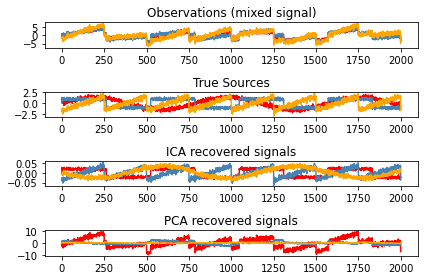

In [3]:
import matplotlib.pyplot as plt

plt.figure()

models = [X, S, S_, H]
names = [
    "Observations (mixed signal)",
    "True Sources",
    "ICA recovered signals",
    "PCA recovered signals",
]
colors = ["red", "steelblue", "orange"]

for ii, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(4, 1, ii)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig, color=color)

plt.tight_layout()
plt.show()

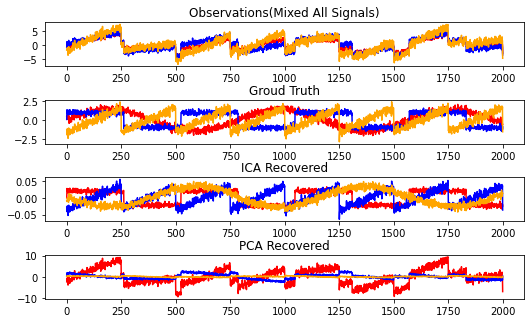

In [4]:
## Plotting the results 

plt.figure()
models = [X, S,S_,H]

names= ['Observations(Mixed All Signals)', 
        'Groud Truth','ICA Recovered', 'PCA Recovered']
colors = ['red', 'blue', 'orange']
for i, (model,name) in enumerate(zip(models,names), 1):
    plt.subplot(4,1,i)
    plt.title(name)
    for sig ,color in zip(model.T,colors):
        plt.plot(sig,color=color)

plt.subplots_adjust(0.39,0.54,1.5,1.5,1,0.76)
plt.show()

From the visual results we can conclude that ICA is the best choice for signal decomposition. So we can use this technique in audio signals noisy reduction, image noise reductions, and to decompose different components from superposition of images 

In [5]:
import numpy as np
import wave

# Read the wave file
mix_1_wave = wave.open('ICA mix 1.wav','r')

In [6]:
mix_1_wave.getparams()

_wave_params(nchannels=1, sampwidth=2, framerate=44100, nframes=264515, comptype='NONE', compname='not compressed')

So this file has only channel (so it's mono sound). It has a frame rate of 44100, which means each second of sound is represented by 44100 integers (integers because the file is in the common PCM 16-bit format). The file has a total of 264515 integers/frames, which means its length in seconds is:

In [7]:
264515/44100

5.998072562358277

Let's extract the frames of the wave file, which will be a part of the dataset we'll run ICA against:



In [8]:

# Extract Raw Audio from Wav File
signal_1_raw = mix_1_wave.readframes(-1)
signal_1 = np.fromstring(signal_1_raw, 'int16')

C:\Users\Admin\AppData\Local\Temp/ipykernel_11576/3469945991.py:3: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  signal_1 = np.fromstring(signal_1_raw, 'int16')


In [9]:
signal_1

array([  879,  1268,  1460, ...,  9204,  9553, 10006], dtype=int16)

In [10]:
'length: ', len(signal_1) , 'first 100 elements: ',signal_1[:100]

('length: ',
 264515,
 'first 100 elements: ',
 array([  879,  1268,  1460,  1756,  1943,  2216,  2407,  2668,  2866,
         3106,  3308,  3546,  3752,  3981,  4175,  4395,  4588,  4790,
         4966,  5146,  5292,  5436,  5550,  5643,  5717,  5759,  5790,
         5798,  5789,  5756,  5713,  5649,  5576,  5478,  5381,  5267,
         5146,  4999,  4856,  4682,  4502,  4308,  4097,  3875,  3637,
         3380,  3107,  2825,  2514,  2194,  1847,  1472,  1087,   671,
          227,  -219,  -691, -1176, -1666, -2167, -2669, -3179, -3668,
        -4170, -4643, -5116, -5559, -5985, -6380, -6765, -7105, -7422,
        -7706, -7955, -8163, -8339, -8470, -8557, -8600, -8618, -8585,
        -8524, -8425, -8298, -8129, -7947, -7720, -7475, -7205, -6916,
        -6606, -6266, -5922, -5556, -5165, -4774, -4353, -3922, -3476,
        -3021], dtype=int16))

If we plot this array as a line graph, we'll get the familiar wave form representation:

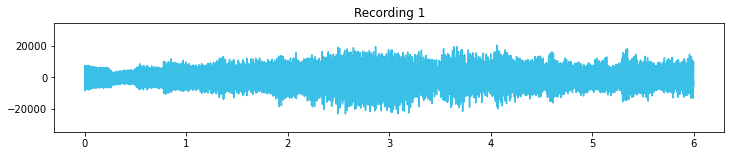

In [11]:
import matplotlib.pyplot as plt

fs = mix_1_wave.getframerate()#The frame rate of a signal is the reciprocal of the frame period T
timing = np.linspace(0, len(signal_1)/fs, num=len(signal_1))


plt.figure(figsize=(12,2))
plt.title('Recording 1')
plt.plot(timing,signal_1, c="#3ABFE7")
plt.ylim(-35000, 35000)
plt.show()

In [28]:
num=len(signal_1)
num

264515

In the same way, we can now load the other two wave files, [ICA mix 2.wav](ICA mix 2.wav) and [ICA mix 3.wav](ICA mix 3.wav)

C:\Users\Admin\AppData\Local\Temp/ipykernel_11576/2850685929.py:5: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  signal_2 = np.fromstring(signal_raw_2, 'int16')
C:\Users\Admin\AppData\Local\Temp/ipykernel_11576/2850685929.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  signal_3 = np.fromstring(signal_raw_3, 'int16')


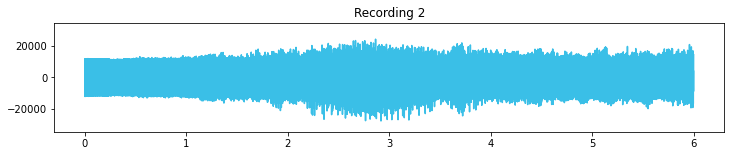

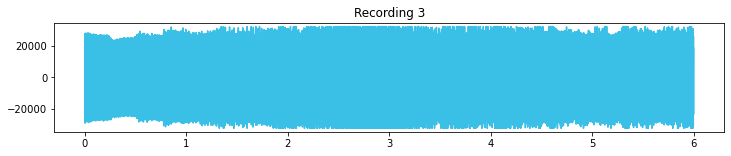

In [12]:
mix_2_wave = wave.open('ICA mix 2.wav','r')

#Extract Raw Audio from Wav File
signal_raw_2 = mix_2_wave.readframes(-1)
signal_2 = np.fromstring(signal_raw_2, 'int16')


mix_3_wave = wave.open('ICA mix 3.wav','r')

#Extract Raw Audio from Wav File
signal_raw_3 = mix_3_wave.readframes(-1)
signal_3 = np.fromstring(signal_raw_3, 'int16')


plt.figure(figsize=(12,2))
plt.title('Recording 2')
plt.plot(timing,signal_2, c="#3ABFE7")
plt.ylim(-35000, 35000)
plt.show()


plt.figure(figsize=(12,2))
plt.title('Recording 3')
plt.plot(timing,signal_3, c="#3ABFE7")
plt.ylim(-35000, 35000)
plt.show()

Now that we've read all three files, we're ready to zip them to create our dataset.

Create dataset X by zipping signal_1, signal_2, and signal_3 into a single list

In [13]:
X = list(zip(signal_1, signal_2, signal_3))

# Let's peak at what X looks like
X[:10]

[(879, 157, 879),
 (1268, 899, 2584),
 (1460, 1610, 4081),
 (1756, 2325, 5682),
 (1943, 3022, 7147),
 (2216, 3718, 8689),
 (2407, 4386, 10114),
 (2668, 5056, 11583),
 (2866, 5690, 12954),
 (3106, 6318, 14327)]

We are now ready to run ICA to try to retrieve the original signals.

Import sklearn's FastICA module
Initialize FastICA look for three components
Run the FastICA algorithm using fit_transform on dataset X

In [14]:
# Import FastICA
from sklearn.decomposition import FastICA

# Initialize FastICA with n_components=3
ica = FastICA(n_components=3)

# Run the FastICA algorithm using fit_transform on dataset X
ica_result = ica.fit_transform(X)

ica_result now contains the result of FastICA, which we hope are the original signals. It's in the shape:



In [15]:
ica_result.shape

(264515, 3)

In [16]:
ica_result

array([[-0.33623699,  0.00365144, -0.00825064],
       [-0.36553666,  0.00257619, -0.09807097],
       [-0.31547887,  0.0044886 , -0.18497588],
       ...,
       [-0.20364565,  1.41167652, -0.99101573],
       [-0.20925198,  1.4420515 , -1.05385147],
       [-0.27552372,  1.46304519, -1.11312822]])

In [17]:
result_signal_1 = ica_result[:,0]
result_signal_2 = ica_result[:,1]
result_signal_3 = ica_result[:,2]

In [18]:
result_signal_1

array([-0.33623699, -0.36553666, -0.31547887, ..., -0.20364565,
       -0.20925198, -0.27552372])

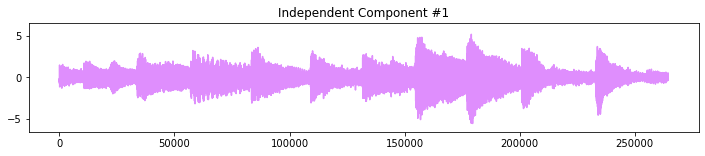

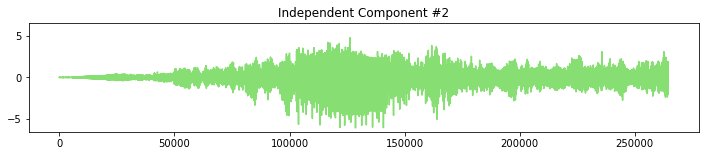

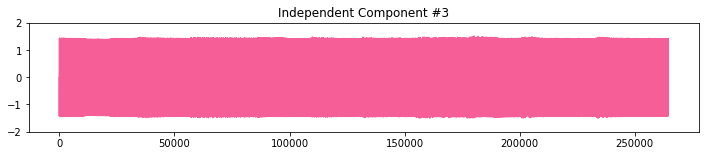

In [19]:
# Plot Independent Component #1
plt.figure(figsize=(12,2))
plt.title('Independent Component #1')
plt.plot(result_signal_1, c="#df8efd")
plt.ylim(-6.50, 6.5)
plt.show()

# Plot Independent Component #2
plt.figure(figsize=(12,2))
plt.title('Independent Component #2')
plt.plot(result_signal_2, c="#87de72")
plt.ylim(-6.50, 6.50)
plt.show()

# Plot Independent Component #3
plt.figure(figsize=(12,2))
plt.title('Independent Component #3')
plt.plot(result_signal_3, c="#f65e97")
plt.ylim(-2.010, 2.010)
plt.show()

Do some of these look like musical wave forms?

The best way to confirm the result is to listen to resulting files. So let's save as wave files and verify. But before we do that, we'll have to:

convert them to integer (so we can save as PCM 16-bit Wave files), otherwise only some media players would be able to play them and others won't
Map the values to the appropriate range for int16 audio. That range is between -32768 and +32767. A basic mapping can be done by multiplying by 32767.
The sounds will be a little faint, we can increase the volume by multiplying by a value like 100

In [20]:
from scipy.io import wavfile

# Convert to int, map the appropriate range, and increase the volume a little bit
result_signal_1_int = np.int16(result_signal_1*32767*100)
result_signal_2_int = np.int16(result_signal_2*32767*100)
result_signal_3_int = np.int16(result_signal_3*32767*100)


# Write wave files
wavfile.write("D:/A IIIT Kota/result_signal_1.wav", fs, result_signal_1_int)
wavfile.write("D:/A IIIT Kota/result_signal_2.wav", fs, result_signal_2_int)
wavfile.write("D:/A IIIT Kota/result_signal_3.wav", fs, result_signal_3_int)

In [21]:
import IPython
IPython.display.Audio("result_signal_3.wav")